In [1]:
%cd /content/drive/MyDrive/AIPI_590/Final Project/Diginetica

/content/drive/MyDrive/AIPI_590/Final Project/Diginetica


In [2]:
import numpy as np
import pandas as pd
import datetime

In [6]:
# This is sample baseline for CIKM Personalization Cup 2016
# by Alexander Laktionov & Vladislav Grozin

import numpy as np
import pandas as pd
import datetime

start_time = datetime.datetime.now()
print("Running baseline. Now it's", start_time.isoformat())

# Loading queries (assuming data placed in <dataset-train/>
queries = pd.read_csv('dataset-train/train-queries.csv', sep=';')[['queryId', 'items', 'is.test']]
print('Total queries', len(queries))

# Leaving only test queries (the ones which items we have to sort)
queries = queries[queries['is.test'] == True][['queryId', 'items']]
print('Test queries', len(queries))
queries.reset_index(inplace=True)
queries.drop(['index'], axis=1, inplace=True)

# Loading item views; taking itemId column
item_views = pd.read_csv('dataset-train/train-item-views.csv', sep=';')[['itemId']]
print('Item views', len(item_views))

# Loading clicks; taking itemId column
clicks = pd.read_csv('dataset-train/train-clicks.csv', sep=';')[['itemId']]
print('Clicks', len(clicks))

# Loading purchases; taking itemId column
purchases = pd.read_csv('dataset-train/train-purchases.csv', sep=';')[['itemId']]
print('Purchases', len(purchases))

# Calculating popularity as [Amount of views] * 1 + Amount of clicks * 2 + [Amount of purchases] * 3
print('Scoring popularity for each item ...')
prod_pop = {}
for cost, container in enumerate([item_views, clicks, purchases]):
    for prod in container.values:
        product = str(prod[0])
        if product not in prod_pop:
            prod_pop[product] = cost
        else:
            prod_pop[product] += cost

print('Popularity scored for', len(prod_pop), 'products')

# For each query:
#   parse items (comma-separated values in last column)
#   sort them by score;
#   write them to the submission file.
# This is longest part; it usually takes around 5 minutes.
print('Sorting items per query by popularity...')

answers = []
step = int(len(queries) / 20)

with open('submission.txt', 'w+') as submission:
    for i, q in enumerate(queries.values):

        # Fancy progressbar
        if i % step == 0:
            print(5 * i / step, '%...')

        # Splitting last column which contains comma-separated items
        items = q[-1].split(',')
        # Getting scores for each item. Also, inverting scores here, so we can use argsort
        items_scores = list(map(lambda x: -prod_pop.get(x, 0), items))
        # Sorting items using items_scores order permutation
        sorted_items = np.array(items)[np.array(items_scores).argsort()]
        # Squashing items together
        s = ','.join(sorted_items)
        # and writing them to submission
        submission.write(str(q[0]) + " " + s + "\n")

end_time = datetime.datetime.now()
print("Done. Now it's ", end_time.isoformat())
print("Calculated baseline in ", (end_time - start_time).seconds, " seconds")

Running baseline. Now it's 2022-11-29T17:44:29.857460
Total queries 923127
Test queries 286967
Item views 1235380
Clicks 1127764
Purchases 18025
Scoring popularity for each item ...
Popularity scored for 128910 products
Sorting items per query by popularity...
0.0 %...
5.0 %...
10.0 %...
15.0 %...
20.0 %...
25.0 %...
30.0 %...
35.0 %...
40.0 %...
45.0 %...
50.0 %...
55.0 %...
60.0 %...
65.0 %...
70.0 %...
75.0 %...
80.0 %...
85.0 %...
90.0 %...
95.0 %...
100.0 %...
Done. Now it's  2022-11-29T17:45:36.058269
Calculated baseline in  66  seconds


In [3]:
purchase_df = pd.read_csv('dataset-train/train-purchases.csv', sep=';')

In [4]:
purchase_df[purchase_df['sessionId']==150]

,sessionId,userId,timeframe,eventdate,ordernumber,itemId
0,150,18278.0,17100868,2016-05-06,16421,25911


In [5]:
clicks_df = pd.read_csv('dataset-train/train-clicks.csv', sep=';')

In [6]:
clicks_df

,queryId,timeframe,itemId
0,1,16338861,24857
1,46255,16404912,30792
2,46689,3831948,8252
3,46731,16273568,33969
4,46748,4058493,7837
...,...,...,...
1127759,980493,630896,42906
1127760,980493,641403,33312
1127761,980493,49028,33312
1127762,980493,573532,5227


In [7]:
views_df = pd.read_csv('dataset-train/train-item-views.csv', sep=';')

In [8]:
views_df[views_df["sessionId"]==150]

,sessionId,userId,itemId,timeframe,eventdate
616,150,NaN,79520,214948,2016-05-06
617,150,NaN,25911,20533,2016-05-06


In [9]:
queries_df = pd.read_csv('dataset-train/train-queries.csv', sep=';',low_memory=False)

In [10]:
lst = list(queries_df[queries_df["sessionId"]==150]['queryId'])

In [13]:
queries_df = queries_df[queries_df['is.test']== False]

In [14]:
clicks_df[clicks_df['queryId'].isin(lst)]

,queryId,timeframe,itemId
490,152,1599121,5045
491,45531,1562860,25911
492,45636,11948071,13889
493,45636,12003222,13889
494,45664,1627804,25911
495,625966,33453784,282057


In [15]:
queries_df.shape

(636160, 10)

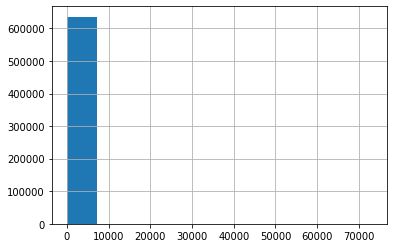

In [16]:
queries_df['duration'].hist()

In [17]:
# queries_df = queries_df[queries_df['duration'] < 10000]

In [18]:
clicks_ses_df = clicks_df.merge(queries_df[['queryId','eventdate','sessionId']], left_on = "queryId", right_on = "queryId", how = "left")

In [19]:
purchase_df = purchase_df[['sessionId','eventdate','itemId']]

In [20]:
purchase_df['is_buy'] = 1

In [21]:
clicks_ses_df = clicks_ses_df[['sessionId','eventdate','itemId']]

In [22]:
clicks_ses_df['is_buy'] = 0

In [23]:
data_df = pd.concat([clicks_ses_df, purchase_df])

In [34]:
data_df.rename(columns={'sessionId': 'session_id_c',
                   'eventdate': 'timestamp',
                   'itemId':'item_id'},
          inplace=True)

In [35]:
data_sort_df = data_df.sort_values(['session_id_c', 'timestamp'], ascending=[True, True])


In [36]:
data_sort_df= data_sort_df.dropna()
data_sort_df = data_sort_df.reset_index(drop=True)

In [37]:
data_sort_df['session_id'] = np.array(data_sort_df.session_id_c)

In [38]:
data_sort_df['item_id'] = np.array(data_sort_df.item_id)

In [39]:
data_sort_df = data_sort_df[['session_id','timestamp','item_id','is_buy']]

In [40]:
data_sort_df['is_buy'] = np.array(data_sort_df.is_buy)

In [69]:
lst_ses = data_sort_df["session_id"].value_counts()

In [70]:
data_sort_df = data_sort_df[(data_sort_df['session_id'].isin(lst_ses[lst_ses>2].index)) & (data_sort_df['session_id'].isin(lst_ses[lst_ses<51].index))]

In [71]:
unq_lst = np.array(data_sort_df.item_id.unique())

In [72]:
idx = [np.where(unq_lst==i)[0][0] for i in data_sort_df['item_id']]

In [73]:
data_sort_df['idx'] = idx

In [74]:
data_sort_df.rename(columns={'item_id': 'item_id_origin',
                   'idx': 'item_id'},
          inplace=True)

In [75]:
data_sort_df = data_sort_df.reset_index(drop=True)

In [76]:
data_sort_df.columns

Index(['session_id', 'timestamp', 'item_id_origin', 'is_buy', 'item_id_origin',
       'item_id'],
      dtype='object')

In [78]:
data = data_sort_df[['session_id', 'timestamp', 'item_id', 'is_buy']]

In [79]:
import os
def to_pickled_df(data_directory, **kwargs):
    for name, df in kwargs.items():
        df.to_pickle(os.path.join(data_directory, name + '.df'))

In [80]:
to_pickled_df('dataset-train', sampled_sessions=data)